In [2]:
import anndata
import gc
import scanpy as sc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [4]:
expr_path = '/data/scRNA/ABCA/AIBS/AWS/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-raw-wmeta.h5ad'
adata = sc.read_h5ad(expr_path)
adata

AnnData object with n_obs × n_vars = 3938808 × 550
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'

**Load modules dataframe**

In [5]:
modules_df = pd.read_csv(
    "/data/scRNA/ABCA/AIBS/AWS/expression_matrices/WMB-10Xv3/20230630/outputs/WMB-10Xv3-CTXsp-sc-wgcna-modules.csv",
    index_col = "Unnamed: 0")
modules_df.head()

,gene_name,module,color,kME_grey,kME_blue,kME_turquoise,kME_yellow,kME_brown,kME_red,kME_green
ENSMUSG00000026712,ENSMUSG00000026712,blue,blue,-0.021587,0.190045,-0.073800,-0.024639,-0.003026,0.004748,-0.038685
ENSMUSG00000029361,ENSMUSG00000029361,turquoise,turquoise,-0.254720,-0.111406,0.376375,-0.127625,-0.076101,-0.052044,-0.089421
ENSMUSG00000038173,ENSMUSG00000038173,yellow,yellow,-0.068901,-0.043119,-0.139840,0.374000,-0.037253,-0.026067,0.081146
ENSMUSG00000029648,ENSMUSG00000029648,brown,brown,-0.093548,0.025604,-0.188880,-0.037207,0.969976,0.117885,-0.119514
ENSMUSG00000044288,ENSMUSG00000044288,turquoise,turquoise,-0.317560,-0.161925,0.528835,-0.169507,-0.120401,-0.071409,-0.069976


Steps to get Module Eigengenes for MERFISH cells:
- Select genes for each module
- Select cells for the brain region
- Process the gene expression data
- Compute PC1
- Visualize

In [6]:
adata.obs.head()

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,
1015221640100570404,C57BL6J-638850.01,8954,0.570219,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.155220,6.507464,0.0,Chol,24 MY Glut,261 HB Calcb Chol,1025 HB Calcb Chol_1,4601 HB Calcb Chol_1,#73E785,#F0A0FF,#EAFF4D,#99007A,#459964
1015221640100800173,C57BL6J-638850.01,8956,0.539178,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.885817,6.597508,0.0,Chol,24 MY Glut,261 HB Calcb Chol,1027 HB Calcb Chol_3,4603 HB Calcb Chol_3,#73E785,#F0A0FF,#EAFF4D,#179982,#5C8B99
1015221640100360300,C57BL6J-638850.01,3988,0.500782,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.151133,5.943029,0.0,Glut,24 MY Glut,243 PGRN-PARN-MDRN Hoxb5 Glut,0975 PGRN-PARN-MDRN Hoxb5 Glut_3,4357 PGRN-PARN-MDRN Hoxb5 Glut_3,#2B93DF,#F0A0FF,#C6FF99,#73FFD9,#AE00CC
1015221640100800090,C57BL6J-638850.01,8956,0.518586,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.849447,6.544510,0.0,Chol,24 MY Glut,261 HB Calcb Chol,1027 HB Calcb Chol_3,4603 HB Calcb Chol_3,#73E785,#F0A0FF,#EAFF4D,#179982,#5C8B99
1015221640100810318,C57BL6J-638850.01,15027,0.506304,C57BL6J-638850,C57BL6J-638850,wt/wt,M,6.251264,5.980208,0.0,Glut,24 MY Glut,243 PGRN-PARN-MDRN Hoxb5 Glut,0979 PGRN-PARN-MDRN Hoxb5 Glut_7,4404 PGRN-PARN-MDRN Hoxb5 Glut_7,#2B93DF,#F0A0FF,#C6FF99,#EFFF26,#2E6655


## Plot cell labels

In [5]:
def plot_section(xx, yy, cc = None, val = None, fig_width = 8, fig_height = 8, cmap = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax

In [6]:
pred = (adata.obs['brain_section_label'] == 'C57BL6J-638850.38')
section = adata.obs[pred]
print("Number of cells in section:",len(section))

Number of cells in section: 120186


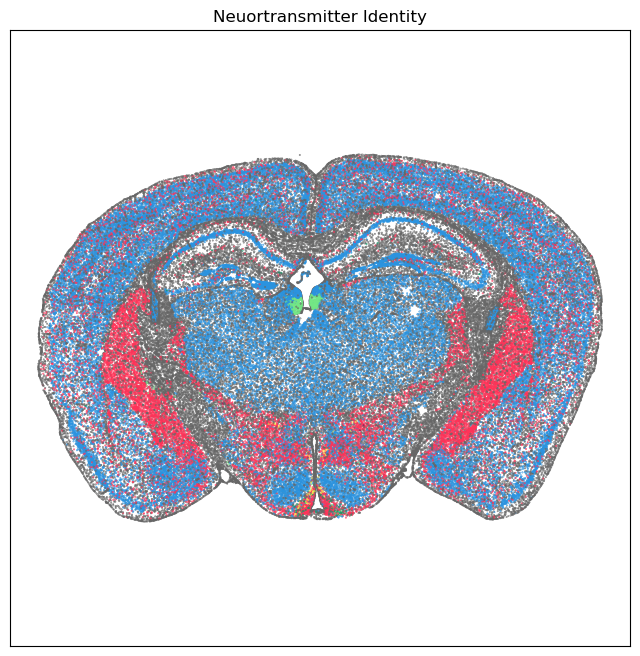

In [8]:
fig, ax = plot_section(section['x'], section['y'], section['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter Identity")
plt.show()

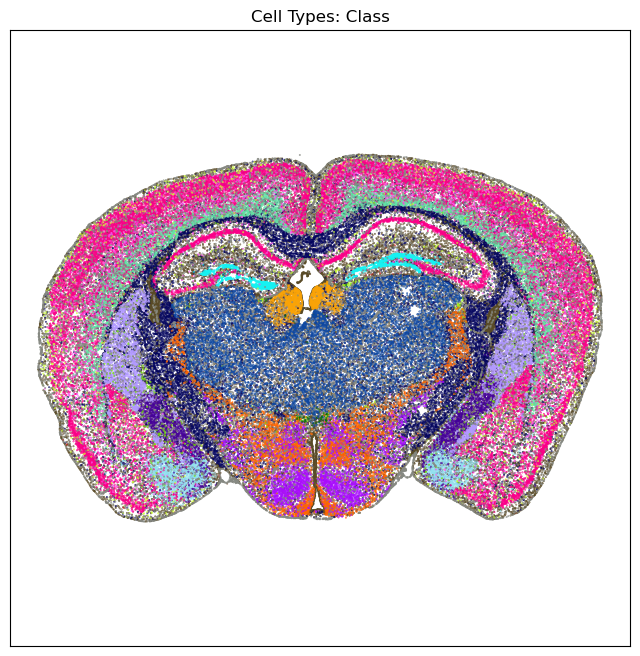

In [9]:
fig, ax = plot_section(section['x'], section['y'], section['class_color'])
res = ax.set_title("Cell Types: Class")
plt.show()

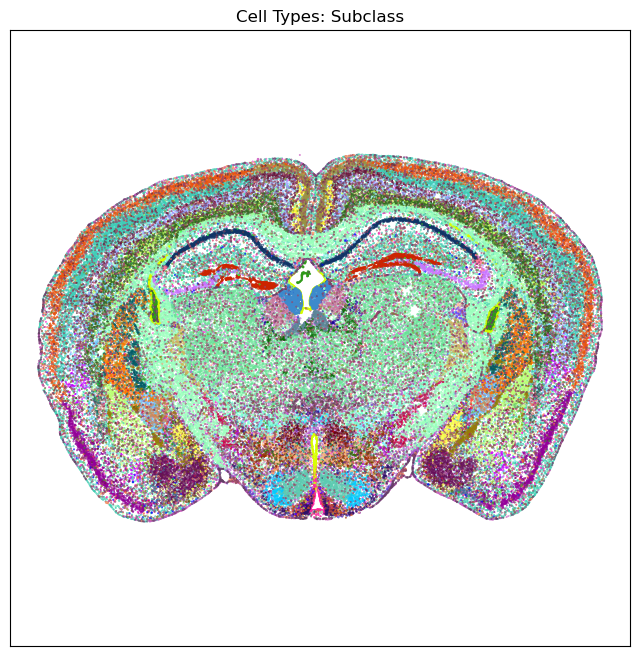

In [10]:
fig, ax = plot_section(section['x'], section['y'], section['subclass_color'])
res = ax.set_title("Cell Types: Subclass")
plt.show()

## Plot expressions

In [11]:
def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap = plt.cm.magma_r):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=5)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

In [14]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol,transcript_identifier
gene_identifier,,
ENSMUSG00000030500,Slc17a6,ENSMUST00000032710
ENSMUSG00000037771,Slc32a1,ENSMUST00000045738
ENSMUSG00000025400,Tac2,ENSMUST00000026466
ENSMUSG00000039728,Slc6a5,ENSMUST00000056442
ENSMUSG00000070570,Slc17a7,ENSMUST00000085374
ENSMUSG00000019935,Slc17a8,ENSMUST00000020102
ENSMUSG00000021609,Slc6a3,ENSMUST00000022100
ENSMUSG00000020838,Slc6a4,ENSMUST00000021195


In [18]:
asubset = adata[:, gene_filtered.index].to_memory()

In [19]:
def create_expression_dataframe(ad, gf):
    gdata = ad[:, gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = section.join(gdata)
    return joined

def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

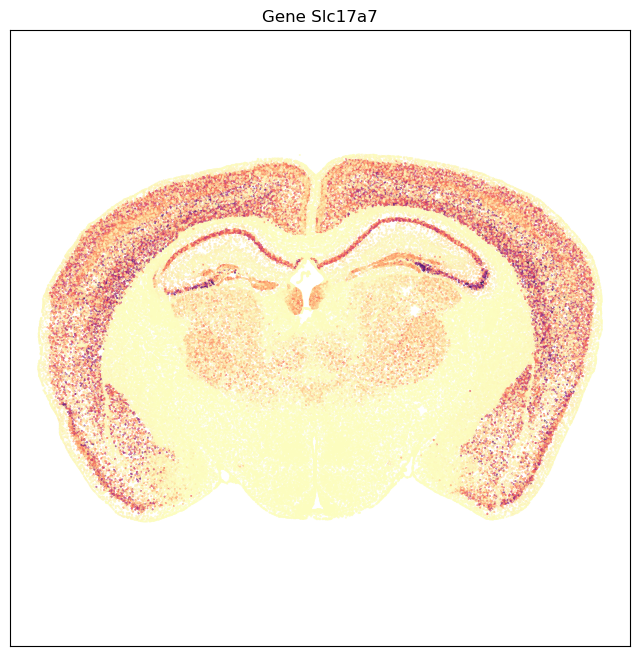

In [21]:
fig, ax = plot_section(ntexp['x'], ntexp['y'], val=ntexp['Slc17a7'], cmap=plt.cm.magma_r)
res = ax.set_title('Gene Slc17a7')
plt.show()

/tmp/ipykernel_42838/1180391112.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(value)[gnames].mean()


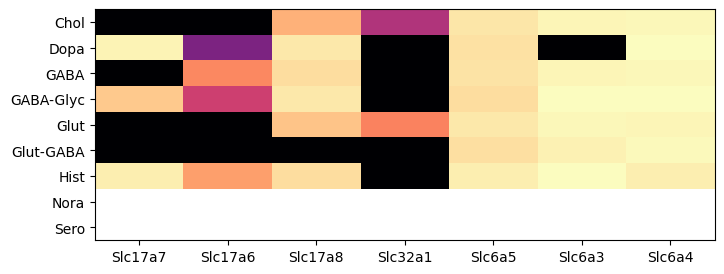

In [20]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe(asubset, gf)
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
agg = agg[ntgenes]
im = plot_heatmap(agg, 8, 3)
plt.show()

## Plot expression over Z

In [7]:
def plot_sections(df, feature, blist, cmap = None, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist):
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]
        
        if cmap is not None :
            ax[idx].scatter(xx, yy, s=1.0, c=vv, marker='.', cmap=cmap)
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0, 11)
        ax[idx].set_ylim(11, 0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s" % (bsl))
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

In [ ]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4']
filtered = exp[ntgenes]
joined = cell.join(filtered)

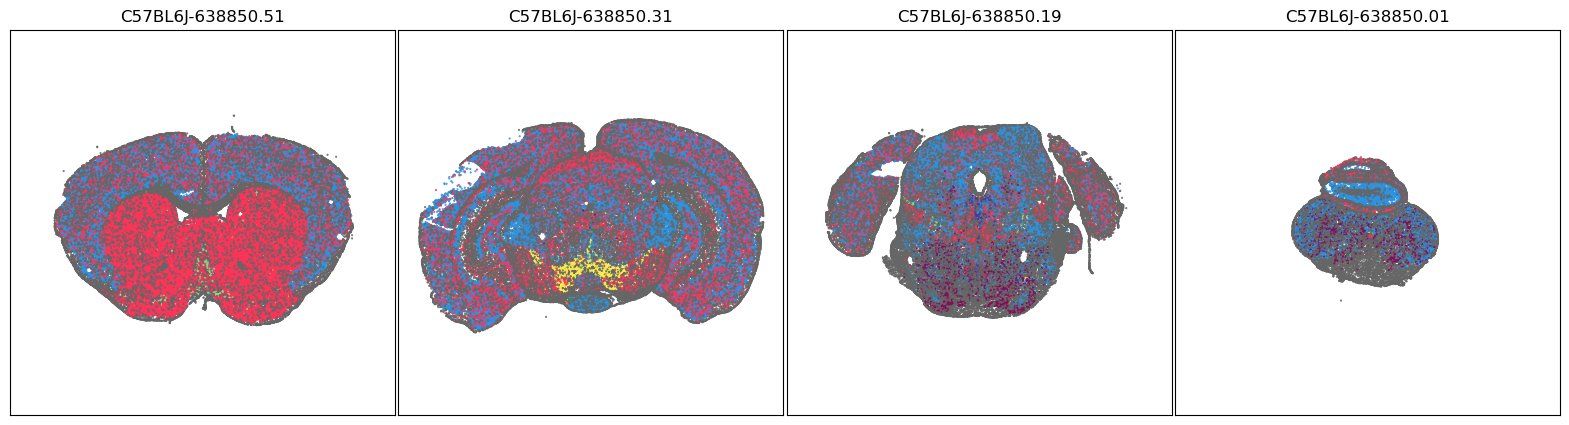

In [9]:
blist = ['C57BL6J-638850.51', 'C57BL6J-638850.31', 'C57BL6J-638850.19', 'C57BL6J-638850.01']
fig, ax = plot_sections(adata.obs, 'neurotransmitter_color', blist, cmap=None)
plt.show()

KeyError: 'Slc17a7'

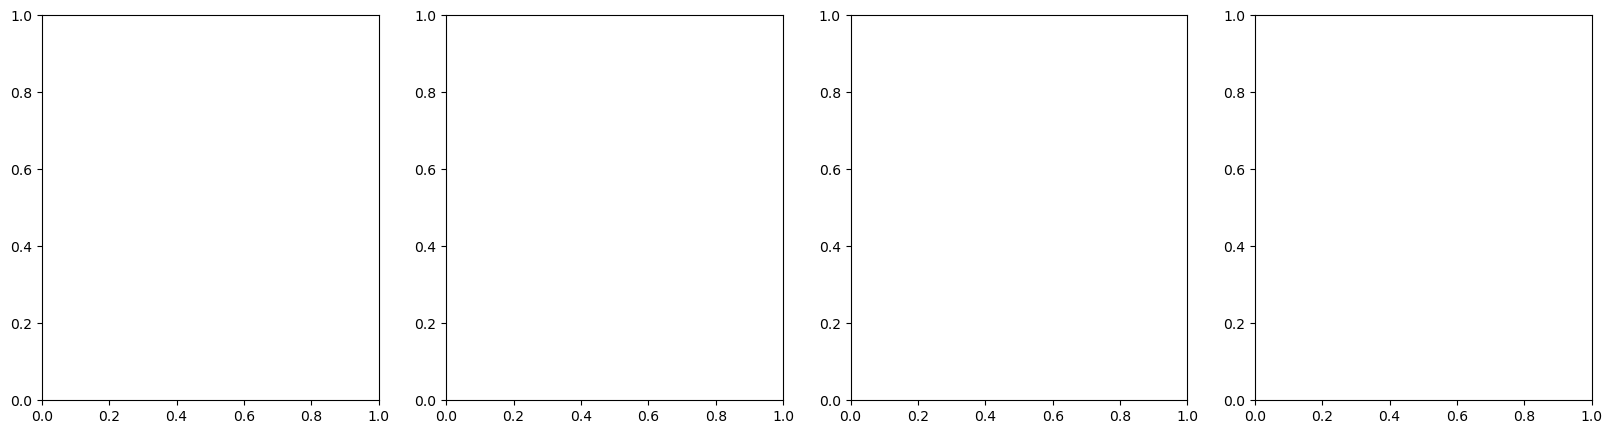

In [10]:
fig, ax = plot_sections(adata.obs, 'Slc17a7', blist, cmap=plt.cm.magma_r)
plt.show()

In [22]:
del adata, asubset
gc.collect()

6531